# Trabajo Práctico 2:  Selección de Variables
## Natalia Mellino

In [1]:
# Imports

## Código de ejemplo dado

In [199]:
#-------------------------------------------------------------------------------------
# AVISO: este codigo esta adaptado de un paquete mayor. 
# No es optimo y tiene cosas inutiles para nosotros. Es un ejemplo nada mas
#
#general forward greedy selection function
#input:
# x,y inputs and targets
# method is an external function that estimates classification error with a given model
# ... parameters for method
#output:
#ordered.names.list <- nombre de las variables ordenadas de la mas importante a la menos
#ordered.features.list <-numero de orden inicial de las variables, con el mismo orden
#importance <- importancia de cada variables en el mismo orden

#-------------------------------------------------------------------------------------
forward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2]
	num.feat<-1
	list.feat<-1:max.feat

	#ranking inicial: elijo la variable con menor error de prediccion
    x.train<-matrix(0,dim(x)[1],1)
	class.error<-double(max.feat)
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train[,1]<-x[,i]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	#guardo la variable con minimo error como primera. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]
	#armo un dataset con las variables que ya elegi, para ir agregando en cada paso.
	x.prev<-x.train[,1]<-x[,list.feat[1]]

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, la agrego al dataset del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
			x.train<-cbind(x.prev,x[,keep.feat[i]])
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan, y actualizo el dataset de partida de la iteracion.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1
		x.prev<-x[,list.feat[1:num.feat]]
	}


	search.names<-colnames(x)[list.feat]
	#le asigno a cada feature una importacia proporcional al orden en que lo seleccionamos
	imp<-(max.feat:1)/max.feat
	names(imp)<-search.names

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",search.names,"\n")
	}

 	return( list(ordered.names.list=search.names,ordered.features.list=list.feat,importance=imp) )

}


#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
	return ( ksvm(x.train, y, type=type,kernel=kernel,C=C,cross = cross)@cross )
}


#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	
	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
	num.feat<-dim(x.train)[2]
	tot.problems<-nlevels(y)*(nlevels(y)-1)/2

	m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)

	w<-rep(0.0,num.feat)
	for(i in 1:tot.problems) for(feat in 1:num.feat)
		w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
	rank.list<-sort(w,decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#filter con kruskal esta en las slides


library(randomForest)
library(kernlab)
library(MASS)

#demo: aplicar el wrapper a los datos de iris
data(iris)
FORW.rf <-forward.ranking(iris[,-5],iris[,5],method="rf.est" ,tot.trees=100,equalize.classes=F)
FORW.lda<-forward.ranking(iris[,-5],iris[,5],method="lda.est")


#hacer una funcion que cree datos, 2 clases (-1 y 1,n puntos de cada una), d dimensiones, de ruido uniforme [-1,1], con la clase al azar

crea.ruido.unif<-function(n=100,d=2){
x<-runif(2*n*d,min=-1)	#genero los datos
dim(x)<-c(2*n,d)
return(cbind(as.data.frame(x),y=factor(rep(c(-1,1),each=n))))	#le agrego la clase
}

#datosA
d<-10
n<-1000
datos<-crea.ruido.unif(n=n,d=d)

#tomar 50% de los datos al azar, y hacer que la clase sea el signo de la 8 variable
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,d+1]<-sign(datos[sub,8])
#tomar 20% de los datos al azar (fuera de los anteriores), y hacer que la clase sea el signo de la 6 variable
sub<-shuffle[(dim(datos)[1]*0.5):(dim(datos)[1]*0.7)]
datos[sub,d+1]<-sign(datos[sub,6])
#tomar 10% de los datos al azar, y hacer que la clase sea el signo de la 4 variable
sub<-shuffle[(dim(datos)[1]*0.7):(dim(datos)[1]*0.8)]
datos[sub,d+1]<-sign(datos[sub,4])
#tomar 5% de los datos al azar, y hacer que la clase sea el signo de la 2 variable
sub<-shuffle[(dim(datos)[1]*0.8):(dim(datos)[1]*0.85)]
datos[sub,d+1]<-sign(datos[sub,2])
datos[,d+1]<-factor(datos[,d+1])

datosA<-datos

#datosB
#generar n=100,d=8
d<-8
n<-1000
datos<-crea.ruido.unif(n=n,d=d)
#hacer que la clase sea el xor de las 2 primeras variables (es usando el signo)
datos[,d+1]<-sign(datos[,1]*datos[,2])
#hacer que las variables 3 y 4 tengan un 50% de correlacion con la clase
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,3]<-abs(datos[sub,3])*datos[sub,d+1]
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,4]<-abs(datos[sub,4])*datos[sub,d+1]
datos[,d+1]<-factor(datos[,d+1])

datosB<-datos



## Ejercicio 1
### Wrapper greedy backward

In [200]:
backward.ranking <- function(x, y, method, ...){

    max.feat = dim(x)[2]
	list.feat = 1 : max.feat
	keep.feat = double(max.feat)
	  
	# Iteraremos hasta que eliminemos todos los features menos 1

	while(length(list.feat) > 1){
		class.error = double(length(list.feat))
		# Entrenamos y medimos el error para cada modelo sacando de a una feature a la vez
		for(i in 1 : length(list.feat)){
			x.train = as.matrix(x[, list.feat[-i]])
			class.error[i] = do.call(method, c(list(x.train, y), list(...)))
		}
		
		# Eliminamos el feature que nos da menos error al sacarlo (es el menos importante)
		min.index = which.min(class.error)
		keep.feat[length(list.feat)] = list.feat[min.index]
		list.feat = list.feat[- min.index]
	}
	
	# El último feature en eliminar es el que haya quedado de las iteraciones anteriores.
	keep.feat[1] = list.feat[1]
	
	# Preparamos la info
	search.names = colnames(x)[keep.feat]
	imp = (max.feat : 1) / max.feat
	names(imp) = search.names
	
 	return(list(ordered.names.list = search.names, 
 	            ordered.features.list = keep.feat, 
 	            imp = imp))

}

###  Filter con test no-paramétrico (Kruskal-Wallis)

In [182]:
kruskal.ranking <- function(x, y){
    
    size <- dim(x)[2]
    ranking <- c()
    for(i in 1 : size){
        feature <- x[, i]
        value <- kruskal.test(feature, y)$statistic
        ranking[i] <- value 
    }

    # Preparamos la info
    ranking <- sort(ranking, decreasing=TRUE, index=T)$ix
	
    search.names = colnames(x)[ranking]

	imp = (size : 1) / size
	names(imp) = search.names
	
    
 	
    return(list(ordered.names.list = search.names, 
 	            ordered.features.list = ranking, 
 	            imp = imp))

    
}

### RFE

In [157]:
rfe.ranking <- function(x, y, method, ...){

    size <- dim(x)[2]
    ranking <- 1 : size
    features <- 1 : size

    for(i in 1 : size){
        train.data <- as.matrix(x[, features])
        rank <- do.call(method, c(list(train.data, y), list(...)) )

        last.ranked <- rank$feats[1]
        
        ranking[size - i + 1] <- features[last.ranked]
        features <- features[-last.ranked]
    }

    # Preparamos la info
	search.names = colnames(x)[ranking]
	imp = (size : 1) / size
	names(imp) = search.names
	
 	return(list(ordered.names.list = search.names, 
 	            ordered.features.list = ranking, 
 	            imp = imp))
}

## Ejercicio 2

In [269]:
# install.packages("gtools") ## Uncomment if not already installed
library(gtools)
mixedorder(c("V10", "V2"))

[1] 2 1

In [273]:


ordernar_nombres <- function(names, values){
    indexes <- mixedorder(names)
    sorted.values <- 1:length(indexes)
    iterator <- 1
    for(i in indexes){
        sorted.values[iterator] <- values[i]
        iterator <- iterator + 1
    }

    return(list(ordered.names=mixedsort(names), ordered.values=sorted.values))
}


In [274]:
graficar_valores <- function(datos){
    datos_ordenados <- ordernar_nombres(datos$ordered.names.list, unname(datos$imp))
    names <- datos_ordenados$ordered.names
    importance <- datos_ordenados$ordered.values
    library(RColorBrewer)
    coul <- brewer.pal(5, "Set2")
    barplot(height=importance, names=names, col=coul)
}

In [192]:
datosA.x = datosA[, -11]
datosA.y = datosA[, 11]
datosB.x = datosB[, -9]
datosB.y = datosB[, 9] 

### Backward ranking con distintas funciones

#### Dataset A

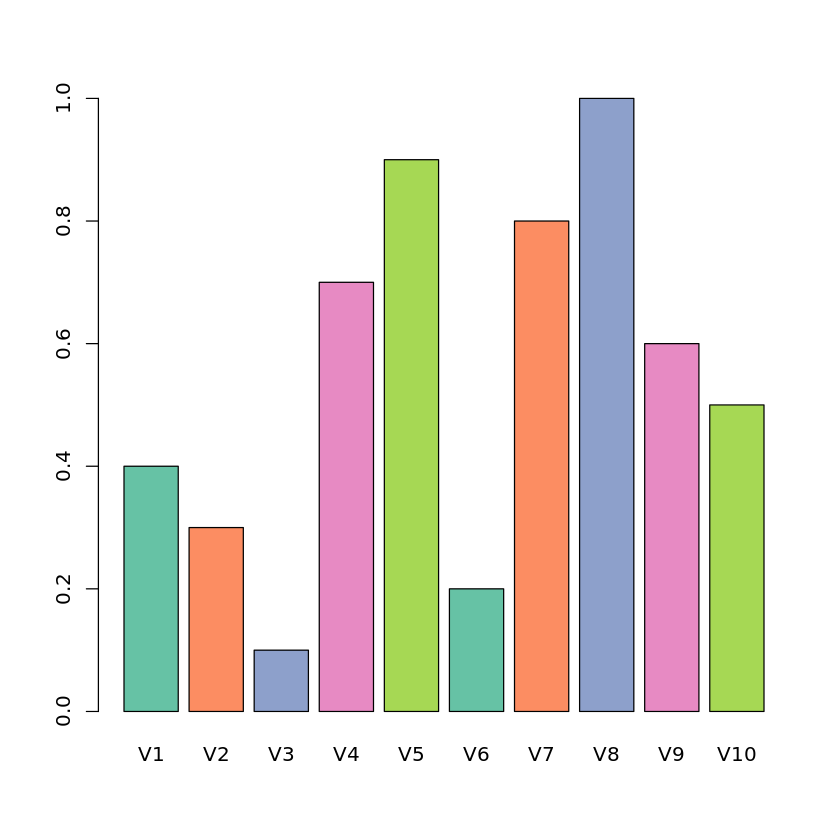

In [276]:
# Random Forest
datos <- backward.ranking(datosA.x, datosA.y, method="rf.est")
graficar_valores(datos)

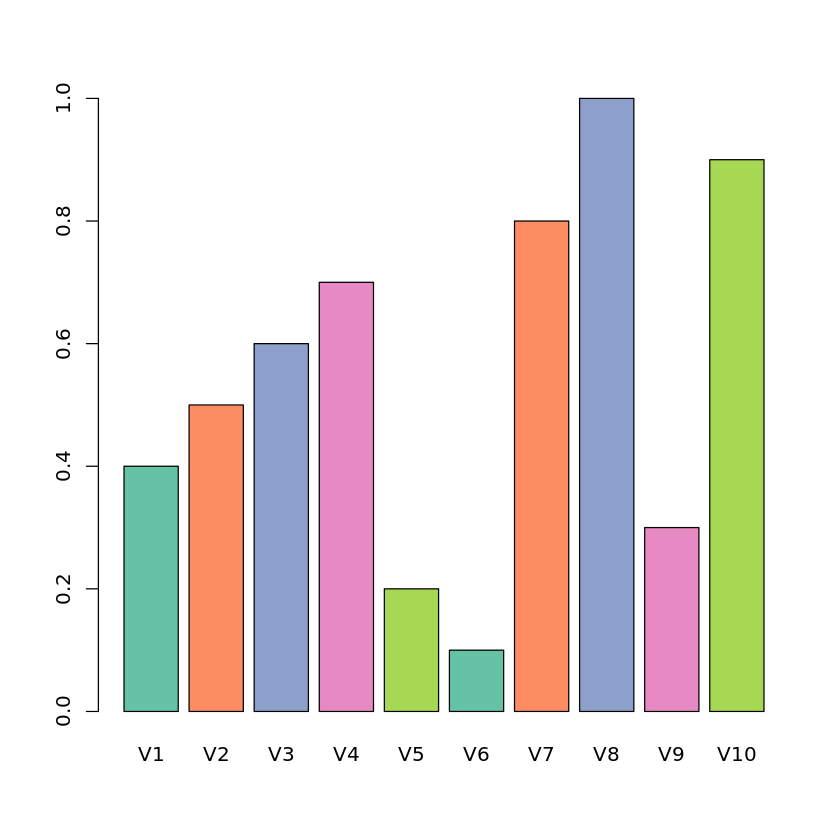

In [275]:
# LDA
datos <- backward.ranking(datosA.x, datosA.y, method="lda.est")
graficar_valores(datos)


 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 

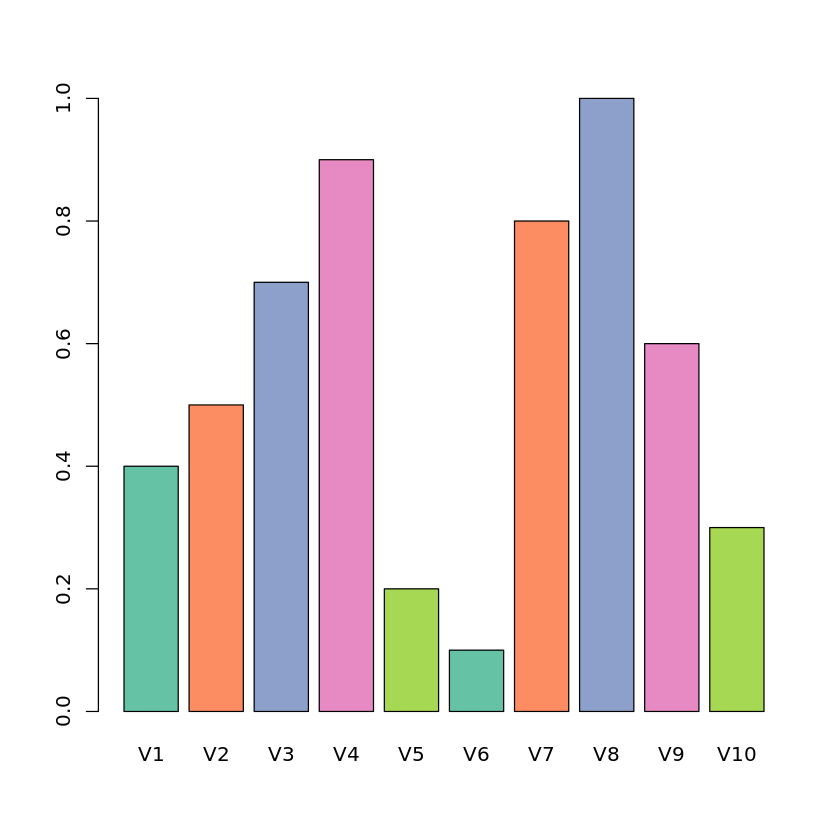

In [278]:
# SVM
datos <- backward.ranking(datosA.x, datosA.y, method="svm.est")
graficar_valores(datos)

#### Dataset B

In [201]:
# Random Forest
backward.ranking(datosB.x, datosB.y, method="rf.est")

$ordered.names.list
[1] "V2" "V1" "V8" "V7" "V6" "V5" "V3" "V4"

$ordered.features.list
[1] 2 1 8 7 6 5 3 4

$imp
   V2    V1    V8    V7    V6    V5    V3    V4 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125

In [202]:
# LDA
backward.ranking(datosB.x, datosB.y, method="lda.est")

$ordered.names.list
[1] "V4" "V3" "V8" "V7" "V6" "V5" "V1" "V2"

$ordered.features.list
[1] 4 3 8 7 6 5 1 2

$imp
   V4    V3    V8    V7    V6    V5    V1    V2 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125

In [203]:
# SVM
backward.ranking(datosB.x, datosB.y, method="svm.est")

 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 

$ordered.names.list
[1] "V4" "V3" "V8" "V5" "V6" "V2" "V7" "V1"

$ordered.features.list
[1] 4 3 8 5 6 2 7 1

$imp
   V4    V3    V8    V5    V6    V2    V7    V1 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125

### Kruskal

### RFE con distintas funciones